<a href="https://colab.research.google.com/github/shreytanwar/Deep-Belief-Network-For-Software-Fault-Prediction-II/blob/main/JustInTime_SW_Pred_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import tensorflow as tf
import sklearn.metrics
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##Preprocessing

In [3]:
bugzilla = pd.read_csv('/content/drive/My Drive/dataset/bugzilla.csv')
columba = pd.read_csv('/content/drive/My Drive/dataset/columba.csv')
jdt = pd.read_csv('/content/drive/My Drive/dataset/jdt.csv')
mozilla = pd.read_csv('/content/drive/My Drive/dataset/mozilla.csv')
platform = pd.read_csv('/content/drive/My Drive/dataset/platform.csv')
postgres = pd.read_csv('/content/drive/My Drive/dataset/postgres.csv')

df = pd.read_csv('/content/drive/My Drive/dataset/FinalDF.csv')

# df = pd.concat([bugzilla, columba, jdt, mozilla, platform, postgres]) 
# df = df.reset_index(drop=True)

In [4]:
def normalize(x):
  x = x.astype(float)
  min = np.min(x)
  max = np.max(x)
  return (x - min)/(max-min)

In [5]:
def view_values(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([-1,1])
    print(image)

In [6]:
print("Shape of dataframe: ", df.shape)  

Shape of dataframe:  (227417, 17)


In [7]:
# Droping unnecessary String columns
df = df.drop(['commitdate','transactionid'], axis=1)

In [8]:
df.head()

,ns,nm,nf,entropy,la,ld,lt,fix,ndev,pd,npt,exp,rexp,sexp,bug
0,1,1,3,0.579380,0.093620,0.000000,480.666667,1,14,596,0.666667,143,133.50,129,1
1,1,1,1,0.000000,0.000000,0.000000,398.000000,1,1,0,1.000000,140,140.00,137,1
2,3,3,52,0.739279,0.183477,0.208913,283.519231,0,23,15836,0.750000,984,818.65,978,0
3,1,1,8,0.685328,0.016039,0.012880,514.375000,1,21,1281,1.000000,579,479.25,550,0
4,2,2,38,0.769776,0.091829,0.072746,366.815789,1,21,6565,0.763158,413,313.25,405,0


In [9]:
# count1 = np.count_nonzero(df.bug, axis=0)
# count1

27866

In [ ]:
# #More Balanced DataFrame
# deleted = 0
# for i in range(df.shape[0]-1, 0, -1 ):
#   if deleted == 164680:
#     break
#   elif df.iloc[i].bug == 0:
#     df = df.drop(df.index[i])
#     if(count1 > np.count_nonzero(df.bug, axis=0)):
#       print('kata')
#       break
#     deleted = deleted + 1
#     if deleted % 1716 == 0:
#       print('Completed: ',deleted / 1716, ' %');

In [11]:
df = df.sample(frac = 1) 

Save the DataFrame

In [12]:
# df.to_csv(r'/content/drive/My Drive/dataset/FinalDF.csv', index = False)

In [13]:
#Splitting Attributes and Labels
train_X = df.iloc[:,:-1].apply(func=normalize, axis=0)
train_Y = df.iloc[:,-1]

In [14]:
# df=df.drop(['transactionid'], axis=1)
print(df.head())

        ns  nm  nf   entropy  ...    exp         rexp   sexp  bug
38070    1   1   1  0.000000  ...    654   452.000000    651    0
67355    1   1   4  0.000000  ...   5446  2027.481746    202    1
23254    1   1   3  0.905713  ...   1217  1154.500000    136    0
11990    1   1   1  0.000000  ...  16736  5511.066667  16736    0
150761   1   3  12  0.731805  ...    265   265.000000     69    1

[5 rows x 15 columns]


#**DBN**

In [15]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)
    # forward pass, where h is the hidden layer and v is the visible layer
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)
    # backward pass
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    # sampling function
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        #To update the weights, we perform constrastive divergence.
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        # We also define the error as the MSE
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X),  self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch,  _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list
    #function to generate new features from the generative model that the RBM has learned
    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

In [16]:
inputX = df.iloc[:,:-1].apply(func=normalize, axis=0).values
inputY= df.iloc[:,-1].values
print(type(inputX))
inputX = inputX.astype(np.float32)

#List to hold RBMs
rbm_list = []

#define parameters of RBMs we will train
# 14-20-12-12-2

# def __init__(self, input_size, output_size,learning_rate, epochs, batchsize):
rbm_list.append(RBM(14, 20, 0.1, 200, 100))
rbm_list.append(RBM(20, 12, 0.05, 200, 100))
rbm_list.append(RBM(12, 12, 0.05, 200, 100))

<class 'numpy.ndarray'>


In [17]:
inputX.shape

(62737, 14)

In [18]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [19]:
outputList = []
error_list = []

#For each RBM in out list
for i in range(0, len(rbm_list)):
    print('RBM', i+1)
    #Train new RBM
    rbm = rbm_list[i]
    err = rbm.train(inputX)
    error_list.append(err)

    #Return output layer
    #sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)
    outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)
    outputList.append(outputX)
    inputX= hiddenX

RBM 1
Instructions for updating:
Use `tf.cast` instead.
Epoch: 0 reconstruction error: 0.108193
Epoch: 1 reconstruction error: 0.108206
Epoch: 2 reconstruction error: 0.108082
Epoch: 3 reconstruction error: 0.107087
Epoch: 4 reconstruction error: 0.106952
Epoch: 5 reconstruction error: 0.104547
Epoch: 6 reconstruction error: 0.107322
Epoch: 7 reconstruction error: 0.105083
Epoch: 8 reconstruction error: 0.104693
Epoch: 9 reconstruction error: 0.103137
Epoch: 10 reconstruction error: 0.104247
Epoch: 11 reconstruction error: 0.104039
Epoch: 12 reconstruction error: 0.101265
Epoch: 13 reconstruction error: 0.100896
Epoch: 14 reconstruction error: 0.100693
Epoch: 15 reconstruction error: 0.100710
Epoch: 16 reconstruction error: 0.099153
Epoch: 17 reconstruction error: 0.097737
Epoch: 18 reconstruction error: 0.097618
Epoch: 19 reconstruction error: 0.097948
Epoch: 20 reconstruction error: 0.099247
Epoch: 21 reconstruction error: 0.096828
Epoch: 22 reconstruction error: 0.095065
Epoch: 23 r

RBM 1


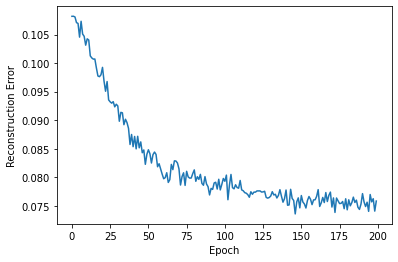

RBM 2


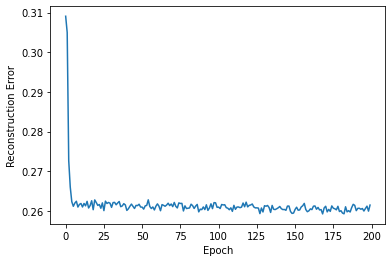

RBM 3


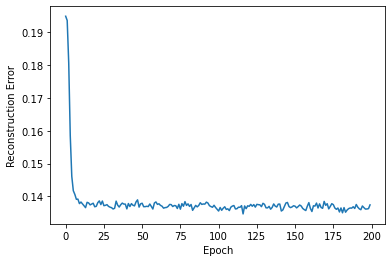

In [20]:
i = 1
for err in error_list:
    print("RBM",i)
    pd.Series(err).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction Error")
    plt.show()
    i += 1

In [21]:
outputX.shape

(62737, 12)

##**Classifier**


Used outputX as the Input for the Classifer

In [23]:
numrows = len(train_Y)
split = (int)(0.8 * numrows)

50189

In [24]:
Y_Train = train_Y.iloc[:split].values
Y_Train.shape

Y_Test = train_Y.iloc[split + 1:].values
Y_Test.shape

(12547,)

In [25]:
X_New_Train = outputX
X_New_Train = X_New_Train[:split, :]
Y_Train = Y_Train.reshape((-1,1))

In [27]:
X_Test = outputX
X_Test = X_Test[split + 1:, :]

ANN

In [22]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [59]:
ann = Sequential()

ann.add(Dense (6, activation = 'relu', input_dim = 12))

ann.add(Dense (6, activation = 'relu'))

ann.add(Dense(1, activation = 'sigmoid'))

ann.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

ann.fit(X_New_Train, Y_Train, batch_size = 200, epochs = 100)

Train on 50189 samples
Epoch 1/100
50189/50189 [==============================] - 0s 5us/sample - loss: 0.6713 - acc: 0.5898
Epoch 2/100
50189/50189 [==============================] - 0s 5us/sample - loss: 0.6634 - acc: 0.6103
Epoch 3/100
50189/50189 [==============================] - 0s 5us/sample - loss: 0.6634 - acc: 0.6109
Epoch 4/100
50189/50189 [==============================] - 0s 6us/sample - loss: 0.6634 - acc: 0.6108
Epoch 5/100
50189/50189 [==============================] - 0s 5us/sample - loss: 0.6635 - acc: 0.6109
Epoch 6/100
50189/50189 [==============================] - 0s 5us/sample - loss: 0.6633 - acc: 0.6105
Epoch 7/100
50189/50189 [==============================] - 0s 5us/sample - loss: 0.6633 - acc: 0.6106
Epoch 8/100
50189/50189 [==============================] - 0s 5us/sample - loss: 0.6634 - acc: 0.6115
Epoch 9/100
50189/50189 [==============================] - 0s 5us/sample - loss: 0.6633 - acc: 0.6119
Epoch 10/100
50189/50189 [==============================] -

##Ensemble
* LogisticRegression
* GaussianNB
* RandomForestClassifier

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [61]:
lr = LogisticRegression(random_state=1)
lr.fit(X_New_Train, row_Y)

forest = RandomForestClassifier(n_estimators=50, random_state=1)
forest.fit(X_New_Train, row_Y)

gnb = GaussianNB()
gnb.fit(X_New_Train, row_Y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [72]:
def preds(mod, op):
  y_preds = mod.predict(op)
  y_preds = (y_pred > 0.5)*1
  return y_preds

In [73]:
def predict(op):
  y_pred = (preds(ann) + preds(lr) + preds(forest) + preds(gnb)) / (4)
  y_pred = (y_pred > 0.5)

##Confusion Matrix

In [74]:

cm = confusion_matrix(train_Y, y_pred)
print(cm) 

[[22398 12473]
 [11926 15940]]


###F1 Score

In [75]:
def f1score( tn, fp, fn, tp):
  precision = tp/(tp + fp)
  print('Precision: ',precision)
  recall = tp/(tp+fn)
  print('Recall: ',recall)
  return 2 * (precision * recall) / (precision + recall)

In [76]:
tn, fp, fn, tp = confusion_matrix(train_Y, y_pred, labels=[0,1]).ravel()
print('F1-score: ',f1score(tn, fp, fn, tp))

Precision:  0.561010804913244
Recall:  0.572023254144836
F1-score:  0.5664635121448497


##Seprate Dataframes

In [78]:
def dbn_op(inputX):
  for i in range(0, len(rbm_list)):
      rbm = rbm_list[i]

      outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)
      inputX= hiddenX
  
  return outputX

In [79]:
def dataframe_score(df1):
  df1 = df1.drop(['commitdate','transactionid'], axis=1)
  train_X_op = df1.iloc[:,:-1].apply(func=normalize, axis=0).astype(np.float32)
  train_Y_op = df1.iloc[:,-1]

  op = dbn_op(train_X_op)

  y_pred_op = classifier.predict(op)
  y_pred_op = (y_pred_op > 0.5)

  cm = confusion_matrix(train_Y_op, y_pred_op)
  print(cm) 

  tn, fp, fn, tp = confusion_matrix(train_Y_op, y_pred_op, labels=[0,1]).ravel()
  print('F1-score: ',f1score(tn, fp, fn, tp))

In [80]:
print('bugzilla:')
dataframe_score(bugzilla)
print('--------------------------------------------------------------------')
print('columba:')
dataframe_score(columba)
print('--------------------------------------------------------------------')
print('jdt:')
dataframe_score(jdt)
print('--------------------------------------------------------------------')
print('mozilla:')
dataframe_score(mozilla)
print('--------------------------------------------------------------------')
print('platform:')
dataframe_score(platform)
print('--------------------------------------------------------------------')
print('postgres:')
dataframe_score(postgres)
print('--------------------------------------------------------------------')
print('Overall:')
cm = confusion_matrix(train_Y, y_pred)
print(cm)
tn, fp, fn, tp = confusion_matrix(train_Y, y_pred, labels=[0,1]).ravel()
print('F1-score: ',f1score(tn, fp, fn, tp))

bugzilla:
[[ 611 2313]
 [ 168 1528]]
Precision:  0.3978130695131476
Recall:  0.9009433962264151
F1-score:  0.5519234242369514
--------------------------------------------------------------------
columba:
[[2028 1066]
 [ 915  446]]
Precision:  0.294973544973545
Recall:  0.32770022042615726
F1-score:  0.3104768534632788
--------------------------------------------------------------------
jdt:
[[20907  9390]
 [ 2806  2283]]
Precision:  0.19557954253405294
Recall:  0.4486146590685793
F1-score:  0.2724018613530605
--------------------------------------------------------------------
mozilla:
[[35211 57915]
 [ 1310  3839]]
Precision:  0.06216601353758461
Recall:  0.7455816663429792
F1-score:  0.11476316458155837
--------------------------------------------------------------------
platform:
[[34046 20752]
 [ 3698  5754]]
Precision:  0.21708292462084056
Recall:  0.6087600507829031
F1-score:  0.3200400467211747
--------------------------------------------------------------------
postgres:
[[8312